In [20]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from app.plotly import train_models
plt.style.use('fivethirtyeight')

In [21]:
from app.database.models import GetData
query = GetData()

df = query.get_to_disease_climate(15)
y_pred = df['influenza'].resample('MS').mean()
y_pred = y_pred.fillna(y_pred.bfill())
y_pred

date1
1997-01-01    2698.142857
1997-02-01    1778.857143
1997-03-01    3263.428571
1997-04-01    1406.571429
1997-05-01    2090.142857
                 ...     
2016-08-01    1294.375000
2016-09-01    1258.000000
2016-10-01    1223.285714
2016-11-01    1216.000000
2016-12-01     677.571429
Freq: MS, Name: influenza, Length: 240, dtype: float64

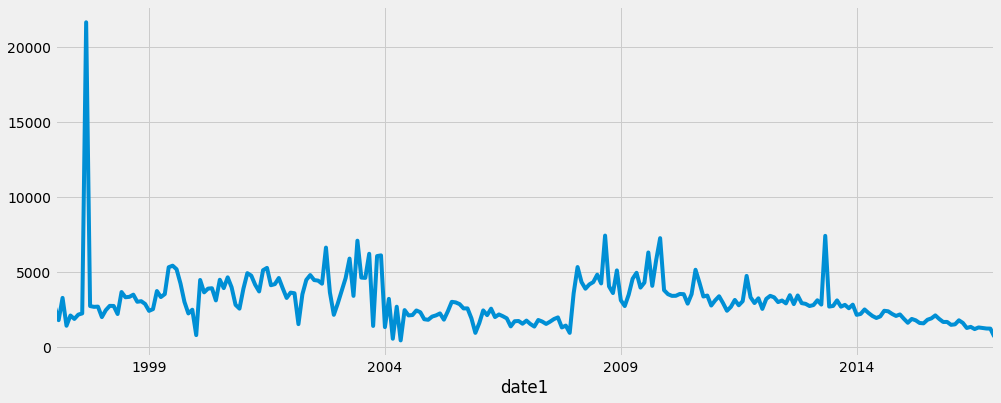

In [22]:
y_pred.plot(figsize=(15, 6))
plt.show()

In [23]:
# Arima time series model
# p,d,q

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_pred,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, min(results.aic)))
        except:
            continue

In [25]:
mod = sm.tsa.statespace.SARIMAX(y_pred,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1345      0.079      1.696      0.090      -0.021       0.290
ma.L1         -0.8142      0.053    -15.471      0.000      -0.917      -0.711
ar.S.L12       0.0837      0.064      1.301      0.193      -0.042       0.210
ma.S.L12      -1.2962      0.097    -13.308      0.000      -1.487      -1.105
sigma2      1.002e+06   1.52e+05      6.592      0.000    7.04e+05     1.3e+06


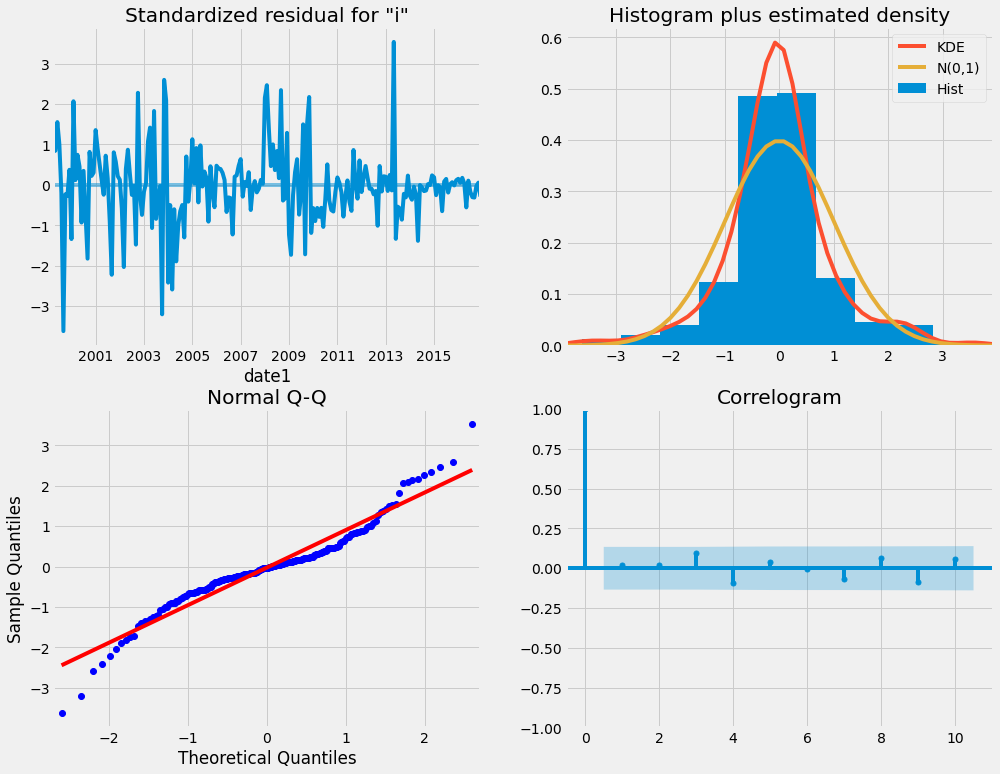

In [26]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [28]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-15'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci
pred

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

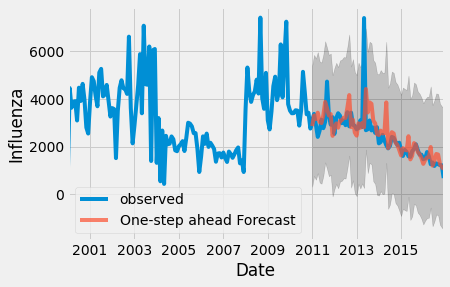

In [71]:
import plotly.graph_objects as go
# ax = y_pred['2000':].plot(label='observed')
ax = y_pred['2000':]
fig = go.Figure()
fig.add_trace(go.Scatter(x=ax.index, y=ax['influenza'],
                    mode='lines',
                    name='lines'))
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Influenza')
plt.legend()

plt.show()

In [72]:
y_forecasted = pred.predicted_mean
y_truth = y_pred['2011-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 559607.92


In [73]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

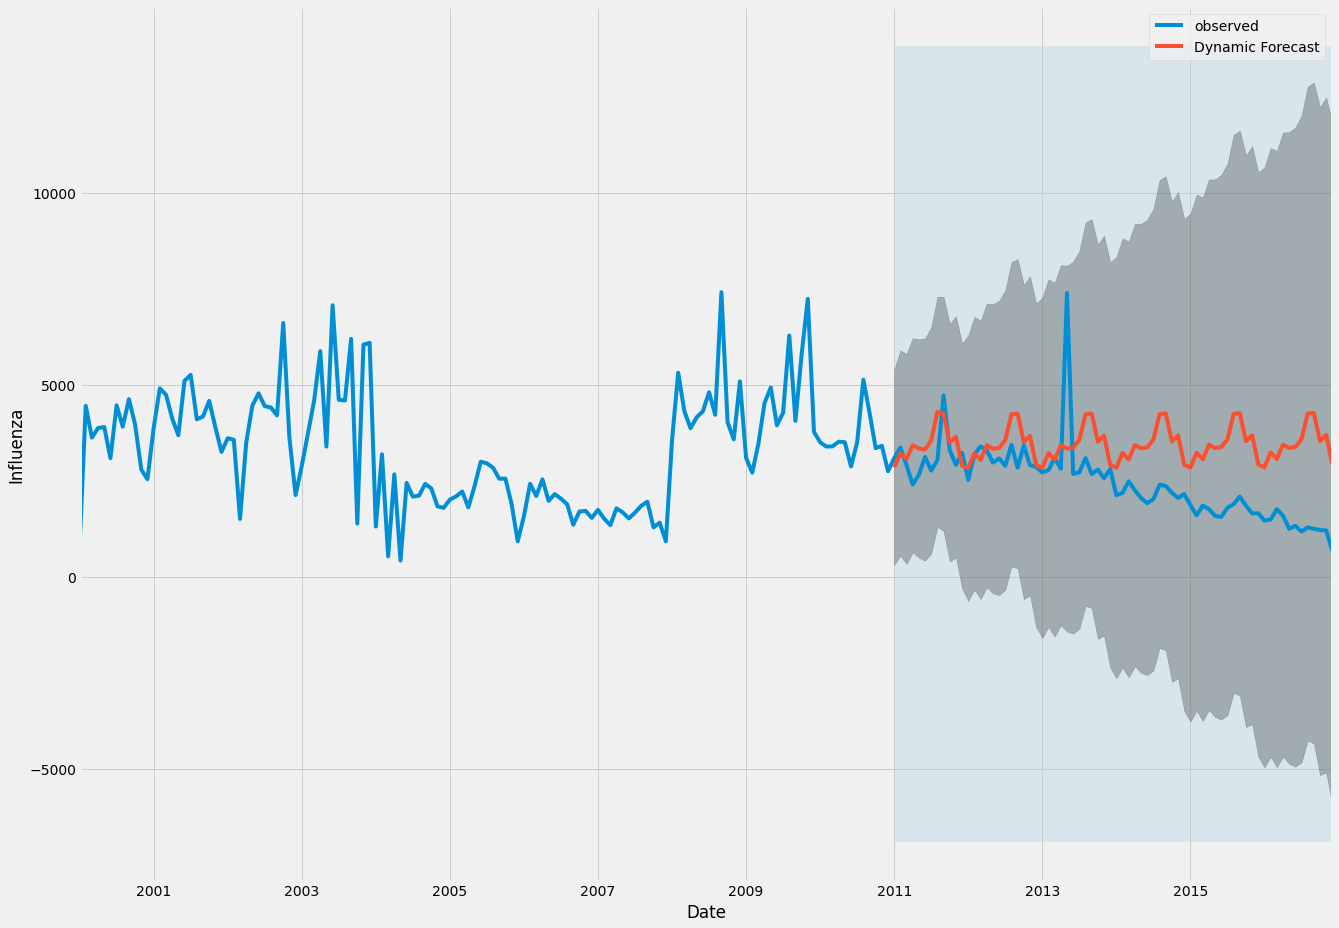

In [75]:
ax = y_pred['2000':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2011-01-01'), y_pred.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Influenza')

plt.legend()
plt.show()

In [76]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y_pred['2011-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2074971.7


In [89]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

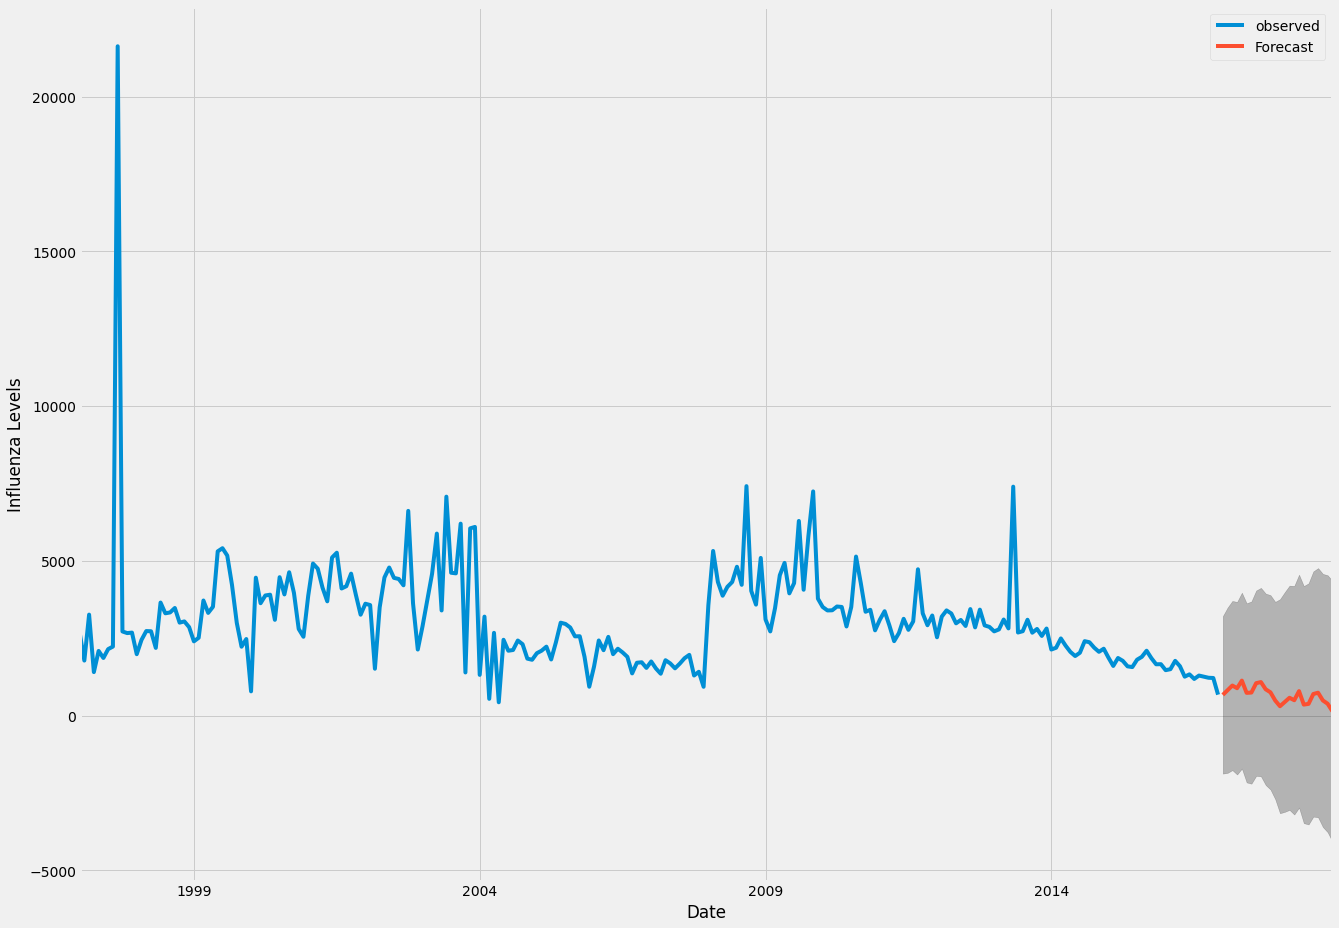

In [90]:
ax = y_pred.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Influenza Levels')

plt.legend()
plt.show()

In [94]:
data = sm.datasets.co2.load_pandas()
y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [2]:
from app.database.models import GetData

query = GetData()
data = query.read_csv_disease(15)
data
data = data['influenza'].resample('MS').mean()
data

date1
1997-01-01    2698.142857
1997-02-01    1778.857143
1997-03-01    3263.428571
1997-04-01    1406.571429
1997-05-01    2090.142857
                 ...     
2019-08-01    2241.000000
2019-09-01    2241.000000
2019-10-01    2241.000000
2019-11-01    2241.000000
2019-12-01    2241.000000
Freq: MS, Name: influenza, Length: 276, dtype: float64

In [7]:
from app.plotly.train_models import test_models

results = test_models(data)

NameError: name 'plt' is not defined

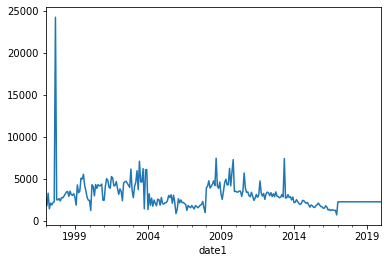

In [4]:
data.plot()
plt.show()

In [8]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.0197,0.076,-0.261,0.794,-0.168,0.128
ma.L1,-1.3941,0.106,-13.189,0.000,-1.601,-1.187
ar.S.L12,0.3957,0.042,9.504,0.000,0.314,0.477
ma.S.L12,-1.1882,0.071,-16.784,0.000,-1.327,-1.049
sigma2,4.607e+05,8.39e+04,5.492,0.000,2.96e+05,6.25e+05


In [10]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'),dynamic=False)
pred_ci = pred.conf_int()
pred_ci

,lower influenza,upper influenza
date1,,
2016-01-01,-913.222155,3495.112604
2016-02-01,-909.420459,3498.994871
2016-03-01,-607.399748,3800.748274
2016-04-01,-642.040117,3766.092206
2016-05-01,-488.508850,3919.616253
2016-06-01,-839.571792,3568.550126
2016-07-01,-747.424333,3660.696197
2016-08-01,-566.006885,3842.113076
2016-09-01,-429.750718,3978.369050


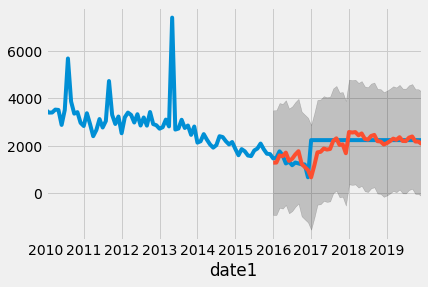

In [14]:
ax = data['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax)
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='k',alpha=.2)


In [16]:
y_forecasted = pred.predicted_mean
y_forecasted
y_truth = data['2016-01-01':]
mse = ((y_forecasted-y_truth)**2).mean()
mse

135022.0257958486

In [19]:
p = d = q = range(0, 2)
p
pdq = [1,2,3]
pdq = tuple(pdq)
pdq

(1, 2, 3)